# Detekcija i rešavanje osmosmerke

In [1]:
from PIL import Image
from pytesseract import Output
import os
import cv2
import pytesseract
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 25, 15

import import_ipynb
from wordsearcher import find_matches
from success_checker import check_cells, check_words, check_matches

importing Jupyter notebook from wordsearcher.ipynb
importing Jupyter notebook from success_checker.ipynb


In [2]:
# poboljšanje rezolucije slike na 300 DPI
def change_resolution(image_path):
    image = Image.open(image_path)
    image.save(image_path, dpi=(300, 300))
    
# učitavanje slike
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# konvertovanje slike u grayscale
def image_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# konvertovanje slike u binarnu
def image_to_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    return cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)[1]

# ispravljanje rotirane slike
def skew_correction(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    # cv2.minAreaRect() vraća vrednosti iz intervala [-90, 0)
    if angle == 0:
        return image
    elif angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)

# uklanjanje šumova
def smoothing_image(image):
    t1 = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)[1]
    t2 = cv2.threshold(t1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    blur = cv2.medianBlur(t2, 1, 0)
    t3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return t3

# otvaranje = erozija + dilacija
def opening(image):
    kernel = np.ones((3, 3))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

# prikaz slike
def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

# dobavljanje okvira osmosmerke
def find_frame(contours, half_height):
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    for i in range(1, len(contours)):
        frame_contour = contours[i]
        x, y, w, h = cv2.boundingRect(frame_contour)
        if y < half_height:
            return (x, y, w, h)

# selektovanje regiona oko slova zadatih reči
def select_letters(image_bin, contours, frame):
    mask = np.zeros(image_bin.shape[:2], dtype=np.uint8)
    sorted_regions = [] 
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        if h < 100 and h > 20:
            # frame[0] je x koordinata gornjeg levog ćoška frame-a, frame[1] je y koordinata, a frame[3] je visina frame-a
            if x < frame[0] or y > frame[1] + frame[3]:
                cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 0, 0), -1)
    return mask        

# isecanje slike na veličinu frame-a
def crop_to_frame(image, frame):
    x, y, w, h = frame
    return image[y:y+h+1, x:x+w+1]

# dobavljanje sortiranih površina unutar kontura
def get_sorted_areas(contours):
    areas = []
    for contour in contours:
        areas.append(cv2.contourArea(contour))
    areas.sort()
    return areas

# uklanjanje slike unutar osmosmerke, ukoliko ona postoji
def remove_image(wordsearch, contours):
    #print(get_sorted_areas(contours))
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    max_area = cv2.contourArea(contours[0])
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        area = cv2.contourArea(contour)
        if area < max_area / 2:
            cv2.rectangle(wordsearch, (x - 10, y - 10), (x + w + 10, y + h + 10), (255, 255, 255), -1)
            return (x, y, w, h)

# uklanjanje crnog okvira oko osmosmerke
def remove_black_frame(image):
    x, y, w, h = 0, 0, image.shape[1], image.shape[0]
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 255), 30)

# primena OCR-a za zadate reči
def ocr_words(image):
    d = pytesseract.image_to_data(image, lang='foo', config='--oem 1', output_type=Output.DICT)
    n_boxes = len(d['text'])
    results = []
    confidences = []
    for i in range(n_boxes):
        if d['conf'][i] != '-1':
            results.append(d['text'][i])
            confidences.append(float(d['conf'][i]))
    
    return d, results, round(sum(confidences) / len(confidences), 2)

# primena OCR-a za osmosmerku
def ocr_wordsearch(image):
    d = pytesseract.image_to_data(image, lang='foo', config='--psm 6 --oem 0', output_type=Output.DICT)
    n_boxes = len(d['text'])
    results = []
    confidences = []
    prev_ln = '0'
    for i in range(n_boxes):
        result = d['text'][i]
        confidence = d['conf'][i]
        ln = d['line_num'][i]
        
        if confidence != '-1':
            if ln == prev_ln:
                results[-1] += result
            else:
                results.append(result)
                prev_ln = ln
            confidences.append(float(confidence))
    
    return d, results, round(sum(confidences) / len(confidences), 2)

# pomoćna funkcija za prikaz nizova
def display_array(array):
    for elem in array:
        print(elem)

# dodavanje razmaka u osmosmerku zbog algoritma pronalaženja
def add_white_space(wordsearch, image_position):
    max_row = max(wordsearch, key=len)
    max_len = len(max_row)
    if any(c in max_row for c in ['Dž', 'Lj', 'Nj']):
        max_len -= 1
    
    rows = []
    for row in wordsearch:
        if len(row) < max_len and image_position == 'r':
            row += ' ' * (max_len - len(row))
        elif len(row) < max_len and image_position == 'l':
            reversed_row = row[::-1]
            reversed_row += ' ' * (max_len - len(row))
            row = reversed_row[::-1]
        rows.append(row)
    
    return rows

# konvertovanje niza stringova u matricu
def array_to_matrix(array):
    rows = []
    for row in array:
        rows.append(list(row))
    return rows

# spajanje karaktera srpske latinice (Dž, Lj, Nj)
def concatenate_chars(matrix):
    for row in matrix:
        for i in range(len(row)):
            if row[i] in ['ž', 'j'] and i != 0:
                row[i - 1] += row.pop(i)
    return matrix

## Pretprocesiranje slika

In [3]:
def preprocess_image(image_path):
    change_resolution(image_path)
    image_color = load_image(image_path)
    image_rotated = skew_correction(image_color)
    image_bin = image_to_bin(image_to_gray(image_rotated))
    image_smooth = smoothing_image(image_bin)
    image = opening(image_smooth) 
    return image_color, image

## Detekcija zadatih reči

In [4]:
def detect_words(image_color, image):
    # prvo pronalazimo okvir osmosmerke, kako bi posmatrali samo reči izvan njega
    contours = cv2.findContours(image.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    frame = find_frame(contours, image.shape[0] / 2)
    x, y, w, h = frame
    cv2.rectangle(image_color, (x, y), (x + w, y + h), (255, 0, 0), -1)
    
    # izolujemo samo regione koji sadrže zadate reči
    mask = select_letters(image, contours, frame) 
    image_words = cv2.bitwise_and(image, image, mask=mask)
    image_words[mask==0] = 255
    
    dict_words, words, confidence = ocr_words(image_words)
    
    return image_words, frame, dict_words, words, confidence

## Detekcija slova u osmosmerci

In [12]:
def detect_wordsearch(image, image_color, frame):
    # isecanje dela slike koji sadrži osmosmerku
    image_wordsearch = crop_to_frame(image, frame)
    contours = cv2.findContours(image_wordsearch.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]

    # uklanjanje slike rešenja unutar osmosmerke
    image_rect = remove_image(image_wordsearch, contours)

    # određivanje pozicije slike unutar osmosmerke
    if image_rect[0] < image.shape[1] / 2:
        image_position = 'l'
    else:
        image_position = 'r'
    
    # uklanjanje crnog okvira oko osmosmerke
    remove_black_frame(image_wordsearch)

    dict_wordsearch, wordsearch, confidence = ocr_wordsearch(image_wordsearch)

    wordsearch = add_white_space(wordsearch, image_position)
    
    return image_wordsearch, dict_wordsearch, wordsearch, confidence

## Rešavanje osmosmerke

## Prikaz i analiza dobijenog rešenja

In [ ]:
for filename in os.listdir('data'):
    image_color, image = preprocess_image('data/' + filename)
    
    image_words, frame, dict_words, words, confidence_words = detect_words(image_color, image)

    image_wordsearch, dict_wordsearch, wordsearch, confidence_wordsearch = detect_wordsearch(image, image_color, frame)
    wordsearch_matrix = concatenate_chars(array_to_matrix(wordsearch))
    
    # OVDE OTVARANJE JSON-a

### Primer

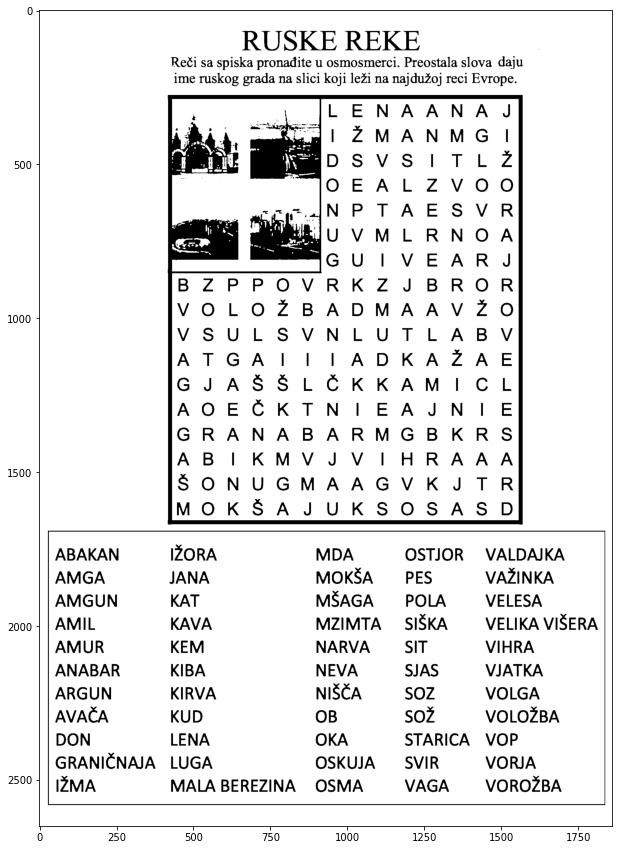

In [6]:
image_color, image = preprocess_image('data/10.jpg')
display_image(image)

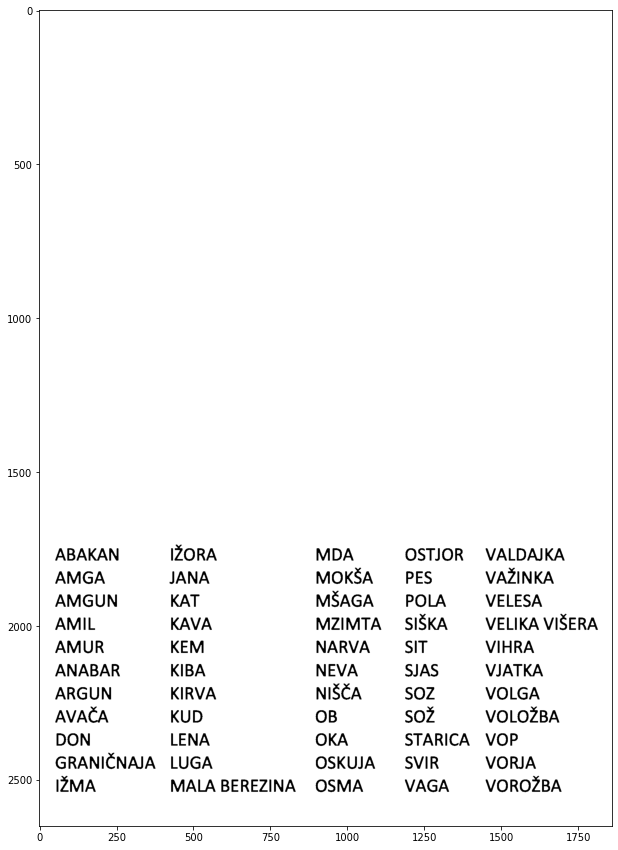

In [7]:
image_words, frame, dict_words, words, confidence_words = detect_words(image_color, image)
display_image(image_words)

In [8]:
print("Prepoznate reči:")
display_array(words)
print("\nProcenat sigurnosti:", confidence_words)

Prepoznate reči:
ABAKAN
AMGA
AMGUN
AMIL
AMUR
ANABAR
ARGUN
AVAČA
DON
GRANIČNAJA
IŽMA
IŽORA
MDA
OSTJOR
JANA
MOKŠA
~
PES
KAT
MŠAGA
„POLA
KAVA
MZIMTA
 „SIŠKA
KEM
NARVA
~
SIT
KIBA
NEVA
SJAS
KIRVA
NIŠČA
SOZ
KUD
OB
SOŽ
LENA
OKA
STARICA
LUGA
OSKUJA
 SVIR
MALA
BEREZINA.
OSMA
VAGA
VALDAJKA
VAŽINKA
VELESA
VELIKA
VIŠERA
VIHRA
VJATKA
VOLGA
VOLOŽBA
VOP
VORJA
VOROŽBA

Procenat sigurnosti: 88.53


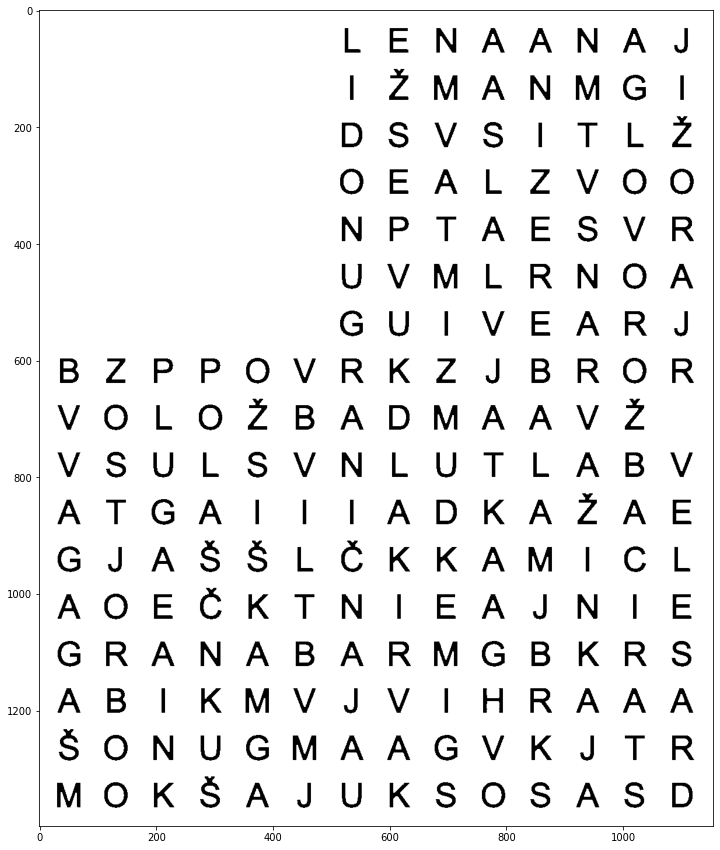

In [13]:
image_wordsearch, dict_wordsearch, wordsearch, confidence_wordsearch = detect_wordsearch(image, image_color, frame)
wordsearch_matrix = concatenate_chars(array_to_matrix(wordsearch))
display_image(image_wordsearch)

In [14]:
print("Prepoznata slova (linije): ")
display_array(wordsearch_matrix)
print("\nProcenat sigurnosti:", confidence_wordsearch)

Prepoznata slova (linije): 
LENAANAJ      
IŽMANMGI      
DSVSITLŽ      
OEALZVOO      
NPTAESVR      
UVMLRNOA      
GUIVEARJ      
BZPPOVRKZJBROR
VOLOŽBADMAAVŽ 
VSULSVNLUTLABV
ATGAI|IADKAŽAE
GJAŠŠLČKKAMICL
AOEČKTNIEAJNIE
GRANABARMGBKRS
ABIKMVJVIHRAAA
ŠONUGMAAGVKJTR
MOKŠAJUKSOSASD

Procenat sigurnosti: 91.64


In [15]:
matches = find_matches(wordsearch, words)
print(len(words))
print(len(matches))

59
46


## Provera rešenja

In [16]:
json_path = 'word-finder/010_rr.json'
json_file = open(json_path)
expected_data = json.load(json_file)
json_file.close()

percent_cells = check_cells(wordsearch, expected_data['cell_data'])
percent_words = check_words(words, expected_data['words'])
percent_matches = check_matches(matches, expected_data['words'])

print(percent_cells)
print(percent_words)
print(percent_matches)

0.9936196700902584
0.9090909090909091
0.45454545454545453
